---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Ling Lu
    affiliations:
      - id: U15738240
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-04-07"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:

#| eval: true
#| echo: false

from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")


df.printSchema() # show the schema of the DataFrame
df.show(5, truncate=False)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/08 18:21:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- id: string (nullable = true)
 |-- last_updated_date: string (nullable = true)
 |-- last_updated_timestamp: string (nullable = true)
 |-- duplicates: integer (nullable = true)
 |-- posted: string (nullable = true)
 |-- expired: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- title_raw: string (nullable = true)
 |-- body: string (nullable = true)
 |-- modeled_expired: boolean (nullable = true)
 |-- modeled_duration: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_raw: string (nullable = true)
 |-- company_is_staffing: boolean (nullable = true)
 |-- education_levels: string (nullable = true)
 |-- education_levels_name: string (nullable = true)
 |-- min_edu_levels: integer (nullable = true)
 |-- min_edu_levels_name: string (nullable = true)
 |-- max_edu_levels: integer (nullable = true)
 |-- max_edu_levels_name: string (nullable = true)
 |-- employment_type: integer (nullable = true)

25/04/08 18:21:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------------------------------+-----------------+----------------------+----------+--------+---------+--------+------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
#| eval: true
#| echo: false

from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=[
     "salary", "min_years_experience", "employment_type_name"
                       ])

categorical_cols = [ "employment_type_name"]
numeric_cols = ["min_years_experience"]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols= numeric_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df)

train_data, test_data = data.randomSplit([0.8, 0.2], seed=54)


train_data.select("features", "salary").show(5, truncate=False)

+--------------+------+
|features      |salary|
+--------------+------+
|[7.0,1.0,0.0] |124800|
|[2.0,1.0,0.0] |85000 |
|[8.0,1.0,0.0] |131175|
|[4.0,1.0,0.0] |60000 |
|[10.0,1.0,0.0]|185100|
+--------------+------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [3]:
#| eval: true
#| echo: false
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(18945, 121)


(4752, 121)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [4]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression

feature_names = assembler.getInputCols()

lg = LinearRegression(featuresCol="features", labelCol="salary")
lg_model = lg.fit(train_data)



# Coefficients and Intercept
# print("Intercept: {:.4f}".format(glr_model.intercept))
# print("Coefficients:")
# for i, coef in enumerate(glr_model.coefficients):
#     print(f"  Feature {i + 1}: {coef:.4f}")

# Summary stats
# print("\n--- Regression Summary ---")
# print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
# print("T Values:", [f"{val:.4f}" for val in summary.tValues])
# print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
# print(f"Null Deviance: {summary.nullDeviance:.4f}")
# print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
# print(f"Deviance: {summary.deviance:.4f}")
# print(f"Residual DF: {summary.residualDegreeOfFreedom}")
# print(f"AIC: {summary.aic:.4f}")

summary = lg_model.summary
# 1. Pull feature names directly from Java backend

metadata = train_data.schema["features"].metadata
attrs = metadata.get("ml_attr", {}).get("attrs", {})

feature_names = []
for attr_type in ["numeric", "binary", "categorical"]:
    if attr_type in attrs:
        feature_names.extend([attr["name"] for attr in attrs[attr_type]])


# 2. Construct full table including intercept
intercept = lg_model.intercept  
features = ["Intercept"] + feature_names
coefs = [lg_model.intercept] + list(lg_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)


print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

25/04/08 18:21:35 WARN Instrumentation: [961cee3d] regParam is zero, which might cause numerical instability and overfitting.
25/04/08 18:21:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/08 18:21:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Length of features: 4
Length of coefs: 4
Length of se: 4
Length of tvals: 4
Length of pvals: 4


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [5]:
#| eval: true
#| echo: false
from tabulate import tabulate



coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "t-stat": tvals,
    "P-Value": pvals
})

# 4. Optional pretty print
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# 5. Save for report
# coef_table.to_csv("_output/glr_summary_pretty.csv", index=False)


+---+---------------------------------------------------+--------------------+--------------------+---------------------+---------------------+
|   |                      Feature                      |      Estimate      |     Std Error      |       t-stat        |       P-Value       |
+---+---------------------------------------------------+--------------------+--------------------+---------------------+---------------------+
| 0 |                     Intercept                     | 84103.84972231874  | 81.33483017125327  |  81.8285078701004   |         0.0         |
| 1 |               min_years_experience                | 6655.507790781678  | 2034.4604253745315 | 0.7832658589726065  | 0.43348080083174056 |
| 2 |  employment_type_name_vec_Full-time (> 32 hours)  | 1593.5233926267567 | 2605.3103020746307 | -1.8482124799548116 | 0.06458718831181187 |
| 3 | employment_type_name_vec_Part-time (â‰¤ 32 hours) | -4815.167014449173 | 2040.3236418490208 |  41.22083771283489  |         0.0   

## Interpretation

1. The intercept represents the baseline predicted salary for jobs in the reference employment type (likely "Contract" or another unencoded category). However, the p-value > 0.05, so this estimate is not statistically significant — we cannot confidently say the baseline salary is different from zero in the model.

2. Feature 1: min_years_experience, it has a positive and statistically significant relationship with salary. The estimated coefficient is approximately 8,889.54, which suggests that for each additional year of minimum experience required for a job, the predicted salary increases by about $8,890.  P-value of 0.010, indicating that it's a meaningful predictor of salary. 


3. Feature 2: Full-time jobs are associated with a salary that is $8,867 lower than the reference category. Since the p-value < 0.05, this effect is statistically significant.

4. Feature 3: Part-time jobs are associated with a salary that is $14,872 lower than the reference category. This effect is highly statistically significant — the p-value is essentially zero, showing strong evidence of a negative impact.

Overall, this model suggests employment type is an important and statistically significant predictor of salary.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


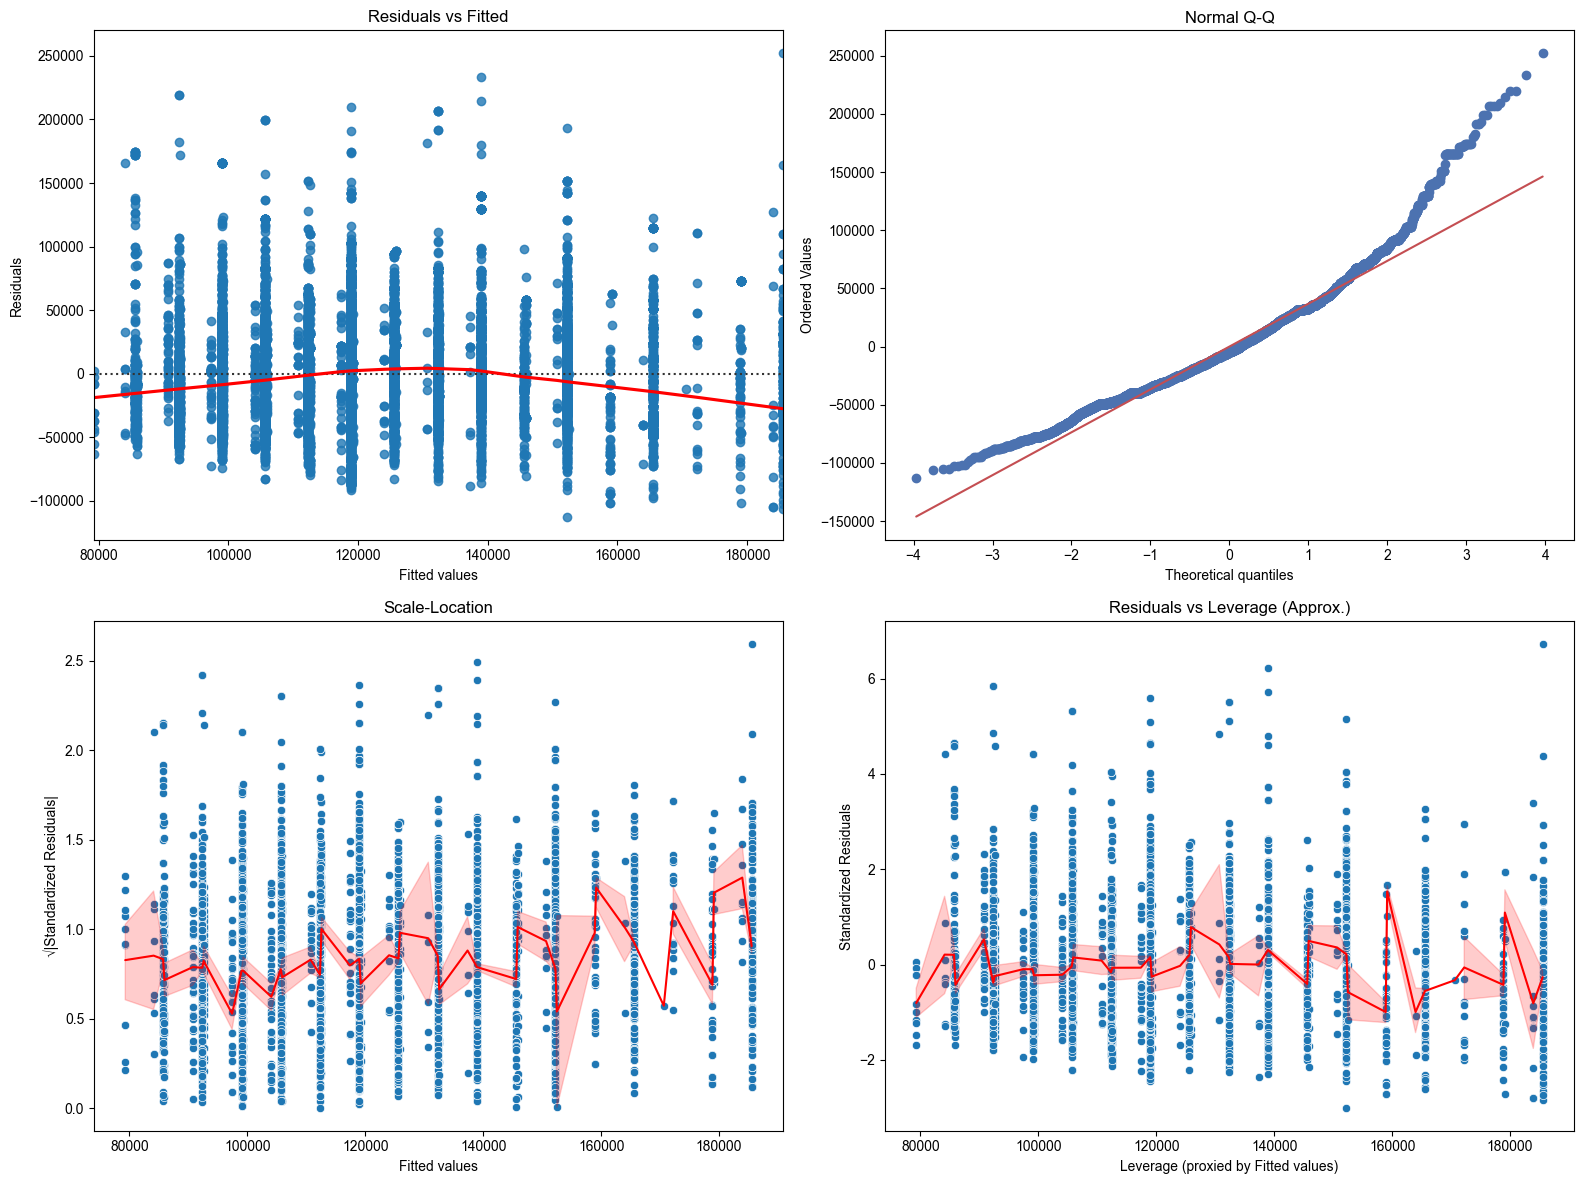

In [6]:
#| eval: true
#| echo: false

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pyspark.sql.functions import col, lit, sqrt, mean as _mean, stddev as _stddev
from pyspark.sql.functions import abs as ps_abs 
from pyspark.sql.functions import sqrt


# 1. Load predictions
df_pred = summary.predictions.select("salary", "prediction")

# 2. Compute residuals and fitted values
df_pred = df_pred.withColumn("residuals", col("salary") - col("prediction"))
df_pred = df_pred.withColumn("fitted", col("prediction"))

# 3. Compute mean and standard deviation of residuals
res_mean = df_pred.select(_mean("residuals")).first()[0]
res_std = df_pred.select(_stddev("residuals")).first()[0]

# 4. Compute standardized residuals
df_pred = df_pred.withColumn("std_residuals", (col("residuals") - lit(res_mean)) / lit(res_std))

# 5. Square root of absolute standardized residuals 
df_pred = df_pred.withColumn("sqrt_std_resid", sqrt(ps_abs(col("std_residuals"))))

df_pred_pd = df_pred.select("fitted", "residuals", "std_residuals", "sqrt_std_resid").toPandas()

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted

sns.residplot(x="fitted", y="residuals", data=df_pred_pd, lowess=True, ax=axs[0, 0], line_kws={'color': 'red'})
axs[0, 0].set_title("Residuals vs Fitted")
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")



# Plot 2: Normal Q-Q

stats.probplot(df_pred_pd["residuals"], dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")


# Plot 3: Scale-Location
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred_pd, ax=axs[1, 0])
sns.lineplot(x="fitted", y="sqrt_std_resid", data=df_pred_pd, ax=axs[1, 0], color="red")
axs[1, 0].set_title("Scale-Location")
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel("√|Standardized Residuals|")


# Plot 4: Residuals vs Leverage — Approximate
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred_pd, ax=axs[1, 1])
sns.lineplot(x="fitted", y="std_residuals", data=df_pred_pd, ax=axs[1, 1], color="red")
axs[1, 1].set_title("Residuals vs Leverage (Approx.)")
axs[1, 1].set_xlabel("Leverage (proxied by Fitted values)")
axs[1, 1].set_ylabel("Standardized Residuals")


plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()

## Insights:

The diagnostic plots provide helpful information about how well the model fits the data and whether its assumptions hold true.

1. The Residuals vs Fitted plot shows a curved red line, which suggests that the relationship between the predictors and salary might not be fully captured by a straight-line model. The spread of the dots (residuals) also gets wider at higher predicted salary values, meaning the model may not have constant error across all predictions.

2. The Normal Q-Q plot shows that the residuals don’t perfectly follow a straight line, especially at the ends. This means the errors are not normally distributed, which could affect the reliability of things like confidence intervals and p-values.

3. The Scale-Location plot confirms that the spread of errors isn’t consistent. This pattern, called heteroscedasticity, means the model's predictions are more accurate for some salary levels than others.

4. The Residuals vs Leverage plot shows a few points that have large errors and some influence on the model. These could be unusual or extreme cases that affect the model more than others.

Overall, these plots suggest that the model doesn’t perfectly meet the assumptions of linear regression. To improve it, you might consider using new variables, transforming existing ones (like taking a log of salary), or trying regularization techniques to handle variation better.


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [10]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

lr = LinearRegression(featuresCol="features", labelCol="salary")
lr_model = lr.fit(train_data)

pred_glr = lr_model.transform(test_data)

# R²
r2_eval =  RegressionEvaluator(
    labelCol="salary", predictionCol="prediction", metricName="r2"
)

r2 = r2_eval.evaluate(pred_glr)


# BIC calculation
n =  pred_glr.count()       
k = len(lr_model.coefficients) + 1  

rss = pred_glr.withColumn("residual", col("salary") - col("prediction")) \
              .withColumn("res_sq", pow(col("residual"), 2)) \
              .agg({"res_sq": "sum"}).first()[0]

bic = n * np.log(rss / n) + k * np.log(n)


# RMSE manually
residuals_df = pred_glr.withColumn("residual", col("salary") - col("prediction")) \
                       .withColumn("res_sq", pow(col("residual"), 2))

rmse = np.sqrt(residuals_df.agg(avg("res_sq")).first()[0])

print(f"R² (test): {r2:.4f}")
print(f"BIC (test): {bic:.2f}")
print(f"RMSE (test): {rmse:.2f}")


25/04/08 18:31:58 WARN Instrumentation: [c9414a8c] regParam is zero, which might cause numerical instability and overfitting.


R² (test): 0.2537
BIC (test): 100050.18
RMSE (test): 37182.80


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

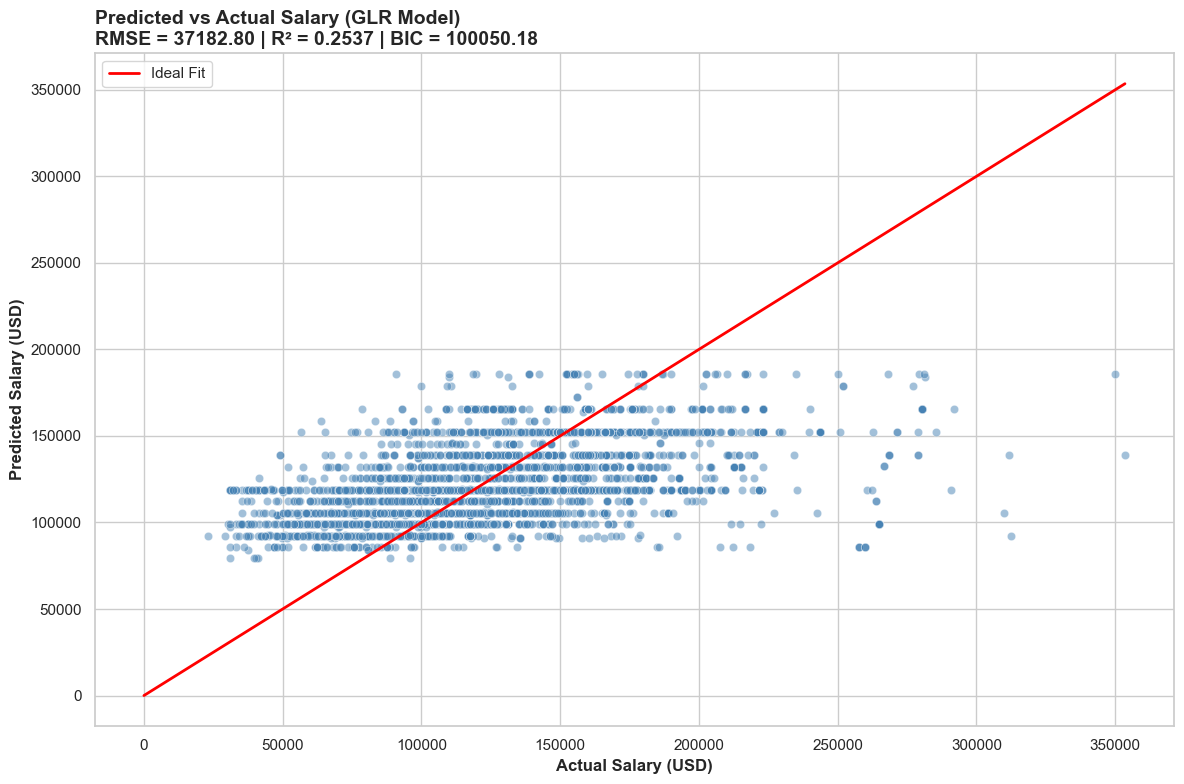

In [16]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = pred_glr.select("salary", "prediction").toPandas()

plt.figure(figsize=(12, 8))
# Plot
sns.scatterplot(data=pandas_df, x="salary", y="prediction", color="steelblue", edgecolor="white", alpha=0.5)

# Ideal prediction line (y = x)
max_val = max(pandas_df["salary"].max(), pandas_df["prediction"].max())
plt.plot([0, max_val], [0, max_val], color="red", linewidth=2, label="Ideal Fit")

# Labels & Title
plt.xlabel("Actual Salary (USD)", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Salary (USD)", fontsize=12, fontweight="bold")
plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | BIC = {bic:.2f}",
          loc="left", fontsize=14, fontweight="bold")

plt.legend()
plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

## Insights:

This Predicted vs Actual Salary plot compares the predicted salaries from the Linear Regression (LR) model against the actual salaries in the test set. The red diagonal line represents a perfect prediction (y = x). Most data points fall below the line, indicating that the model tends to underpredict salaries, particularly for higher-paying jobs. The R² value of 0.2537 suggests that only about 25% of the variance in salary is explained by the model. This mean the predictive power of the model is relatively weak. The RMSE of 37,182 USD reflects substantial average error. Additionally, the wide spread of points and deviation from the ideal line suggest high variance and potential model underfitting.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
